# Examples:
Let's look at some of the most commonly used things this library can do to collect and post-process IQ data from an RTL-SDR.

In [1]:
from rtlobs import collect as col
from rtlobs import post_process as post

### Total power
We can find the total power incident on the SDR by integrating the complex samples at a certain frequency for an amount of time:

In [2]:
# 1024 complex samples per call to the SDR
# 49.6 dB of RtlSdr gain
# 2.4 MHz sample rate/bandwidth
# 1420.6 MHz center frequency
# 10 sec integration time
p_tot = col.run_total_power_int(1024, 49.6, 2.4e6, 1420.4e6, 10)
print('Uncalibrated total power measurement: {}'.format(p_tot))

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.4 MHz
  center frequency 1420.4 MHz
  gain: 49.6 dB
  num samples per call: 1024
  requested integration time: 10s
  => num samples to collect: 24000000
  => est. num of calls: 23437
Integration began at Fri, 28 Feb 2020 19:40:20
Integration ended at Fri, 28 Feb 2020 19:40:31 after 11.02284049987793 seconds.
23437 calls were made to SDR.
23999488 samples were measured at 1420.4 MHz
for an effective integration time of 10.00s
Uncalibrated total power measurement: 0.0027468171480417446


### Total power calibration 
If p_tot was measured with a telescope pointed at a radio-hot source (e.g. the ground, ~300 Kelvin), and we measure again, this time pointed at a radio-cold source (e.g. empty sky, estimates vary, say ~10 K):

In [3]:
p_hot = p_tot
p_cold = col.run_total_power_int(1024, 49.6, 2.4e6, 1420.4e6, 10)
print('Uncalibrated total power measurement: {}'.format(p_cold))

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.4 MHz
  center frequency 1420.4 MHz
  gain: 49.6 dB
  num samples per call: 1024
  requested integration time: 10s
  => num samples to collect: 24000000
  => est. num of calls: 23437
Integration began at Fri, 28 Feb 2020 19:41:16
Integration ended at Fri, 28 Feb 2020 19:41:27 after 11.23639440536499 seconds.
23437 calls were made to SDR.
23999488 samples were measured at 1420.4 MHz
for an effective integration time of 10.00s
Uncalibrated total power measurement: 0.00272043848456643


We can use these power measurements and assumptions of brightness temperature to perform a "Y-factor" calibration of the system temperature, T_sys, as described in [Single-Dish Calibration Techniques at Radio Wavelengths, K. O'Neil, 2002](http://adsabs.harvard.edu/full/2002ASPC..278..293O):

In [4]:
from rtlobs import calibrate as cal
t_sys = cal.y_factor_cal(p_hot, p_cold, 300, 10)

T_sys estimate for cold load temp 10.00K and hot load temp 300.00K is 29897.78K


If your assumptions are wrong (for instance, pointing at the ceiling then a window, instead of ground, then sky), T_sys might not come out what you expect.

### Spectral lines
We can estimate the power spectral density recorded by the SDR for a given bandwidth by averaging multiple spectra over time to reduce the noise:

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.320000 MHz
  center frequency 1420.000000 MHz
  gain: 49 dB
  num samples per call: 8192
  PSD binning: 2048 bins
  requested integration time: 10s
  => num samples to collect: 23200000
  => est. num of calls: 2832
Integration began at Fri, 28 Feb 2020 19:43:54


/usr/lib/python3/dist-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Integration ended at Fri, 28 Feb 2020 19:44:56 after 61.159624338150024 seconds.
2832 spectra were measured at 1420000000.0.
for an effective integration time of 10.00s


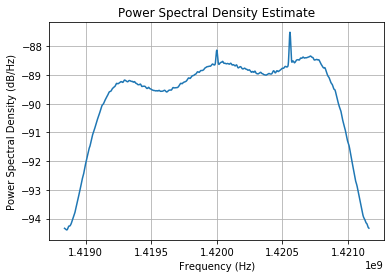

In [5]:
from rtlobs import collect as col
from rtlobs import post_process as post
# 8192 samples per call to the SDR
# 2048 bin resolution power spectral density estimate
# 49.6 dB of RtlSdr gain
# 2.32 MHz sample rate/bandwidth
# 1.420 GHz center frequency
# 10 sec integration time
f, p = col.run_spectrum_int(8192, 2048, 49.6, 2.32e6, 1.420e9, 10)
# Show the figure containing the plotted spectrum
fig, ax = post.plot_spectrum(f, p, savefig='../images/spectrum_int.png')

And we can even run in frequency-switching mode, periodically retuning the SDR between two frequencies to reduce baseline bandpass shape and increase signal-to-noise on a spectral line!

Note that the folding process performed on frequency-switched data happens in terms of the absolute values (power) rather than relative values (dB), so we make those changes to the plot labels.

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.048000 MHz
  center frequency 88.950000 MHz
  gain: 49 dB
  num samples per call: 8192
  requested integration time: 5.0s
  => num samples to collect: 10240000
  => est. num of calls: 1250
  => num samples on each dwell: 409600
  => est. num of calls on each dwell: 50
  => num dwells total: 25
Integration began at Fri, 28 Feb 2020 19:50:07
Integration ended at Fri, 28 Feb 2020 19:50:14 after 7.590336799621582 seconds.
1250 spectra were measured, split between 88950000.0 and 89250000.0.
for an effective integration time of 5.00s


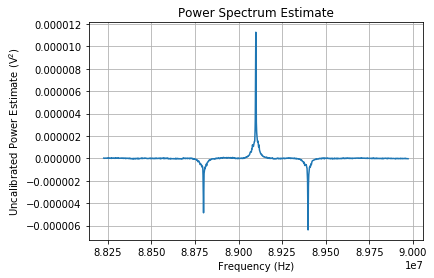

In [6]:
f, p = col.run_fswitch_int(8192, 2048, 49.6, 2.048e6, 88.95e6, 89.25e6, 5.0, fswitch=5)
fig, ax = post.plot_spectrum(f, p)
# Edit figure labels to be technically correct
ax.set_ylabel('Uncalibrated Power Estimate (V$^2$)')
ax.set_title('Power Spectrum Estimate')
fig.savefig('../images/fswitch_int.png')